In [105]:
#default_exp bert

# Transformer

Here we are going to tackle the mighty transformer module which revolutionized the NLP world in 2016. We are going to code transformer by ourselves and train for a small task. We hope to gain more understanding of inner workings of tranformer through this way.

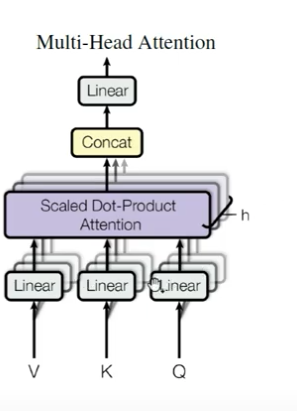

Lets tackle the self attention first. This is the most complicated module.

Main idea is:
* divide embedding dimension into different parts
* pass them through the linear transformation
* get scaled dot product attention
* concat them at the end
* pass through linear layer

In [106]:
#export

import torch
import torch.nn as nn
import torch.nn.functional as F

In [125]:
#export
class SelfAttention(nn.Module):
    def __init__(self, embed_size: int= 256, heads: int = 8):
        ''' 
             Implementing self attention module
             embed_size: embedding size of the input
             heads: target number of splits in the input dimension
        '''
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        
        assert (self.head_dim * heads == self.embed_size), "Embedding size needs to be multiple of heads"
        
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries= nn.Linear(self.head_dim, self.head_dim, bias=False)
        
        # concatenation them again
        self.fc_out = nn.Linear( heads * self.head_dim, embed_size)
        
    
    def forward(self, values, keys, queries , mask=None):
        N = queries.shape[0]
        
        value_len, key_len, query_len = values.shape[1], keys.shape[1], queries.shape[1]
        
        # split embedding into self.heads pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)
        
        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)
        
        energy = torch.einsum("nqhd,nkhd->nhqk", queries, keys)
        # query shape: ( N, query_len, heads, heads_dim)
        # keys shape: (N, key_len, heads, heads_dim)
        # energy shape : (N, heads,query_len, key_len)
        
        # check mask
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float('-inf'))
        
        
        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3) 
        
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values])
        
        # attention shape ( N , heads, query_len, key_len)
        # values shape ( N, values_len, heads, heads_dim)
        # (N, query_len, heads, head_dim )
        
        # concatenate
        out = out.reshape(N, query_len, self.heads * self.head_dim)
        
        return self.fc_out(out), attention
        
        
        
        
        
        

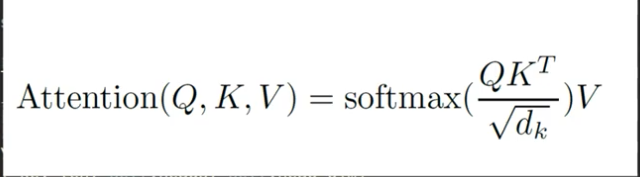

In [128]:
sa = SelfAttention()
inp = torch.randn(32, 512, 256)
sa(inp, inp, inp)[0].shape

torch.Size([32, 512, 256])

Here we created a module that knows how to pay attention to neighboring words. Similar to RNN but have an infinite receptive field

# TransformBlock

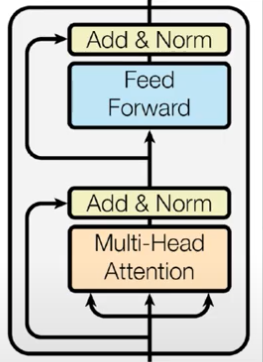

In [129]:
#export
class TransformerBlock(nn.Module):
    def __init__(self, embed_size:int = 256, heads:int = 8, dropout:float =0.2, forward_expansion:int = 4):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size , embed_size)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask=None):
        x, attention = self.attention(value, key, query, mask)
        x = self.dropout(self.norm1(x + query))
        
        forward = self.feed_forward(x)
        
        out = self.dropout(self.norm2(forward))
        
        return out, attention
         

In [131]:
tb = TransformerBlock()
inp = torch.randn(32, 512, 256)
tb(inp, inp, inp, mask=None)[1].shape

torch.Size([32, 8, 512, 512])

# Encoder block

Now we will focus on Encoder block which will be combination of transformation blocks.

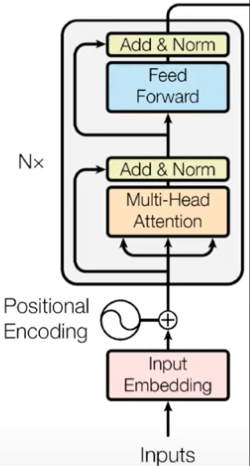

In [150]:
#export
class Encoder(nn.Module):
    def __init__(self, src_vocab_size=1000, 
                 embed_size=256, num_layers=6,
                heads=8, device = torch.device('cpu'),
                forward_expansion=4,
                dropout=0.2,
                max_length=512):
        super(Encoder, self).__init__()
        self.device = device
        self.embed_size = embed_size
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)
        
        self.layers = nn.ModuleList(
            [TransformerBlock(embed_size, heads, dropout = dropout,
                             forward_expansion = forward_expansion) for _ in range(num_layers)]
        )
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x , mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).long().to(self.device)
        
        out = self.dropout(self.word_embedding(x) + self.position_embedding(positions))
        
        for layer in self.layers:
            out,_ = layer(out, out, out , mask)
            
        return out
                

In [151]:
enc = Encoder(num_layers=2)
inp = torch.randint(low=0,high=1000,size=(32,512))
enc(inp, mask=None).shape

torch.Size([32, 512, 256])

# Decoder block

Decoder block will be similar to encoder block but with attention mask

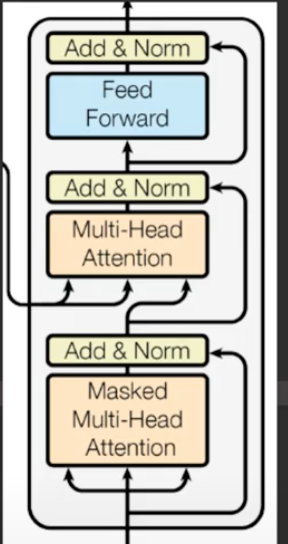

In [152]:
#export
class DecoderBlock(nn.Module):
    def __init__(self, embed_size=256, heads = 8, forward_expansion = 4, dropout = 0.2, device = torch.device('cpu')):
        super(DecoderBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(
                embed_size,
                heads,
                dropout,
                forward_expansion
        )
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, value, key, src_mask, trg_mask):
        ''' Src_mask is optional . its used to not pay attention to src pads '''
        xtransformed, _ = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm( xtransformed + x))
        
        out, attention = self.transformer_block(value, key, query, src_mask)
        
        return out, attention

In [153]:
db = DecoderBlock()
dec_inp = torch.randn(32, 512, 256)
enc_out = torch.randn(32, 512, 256)
db(dec_inp, enc_out, enc_out, src_mask=None, trg_mask=None)[1].shape

torch.Size([32, 8, 512, 512])

# Decoder

Now, it takes the input, applies the embedding and calls decoder block multiple times with encoder output

In [154]:
#export
class Decoder(nn.Module):
    def __init__(self,
                trg_vocab_size=1000,
                embed_size=256,
                num_layers=6,
                heads=8,
                forward_expansion=4,
                dropout=0.2,
                device=torch.device('cpu'),
                max_length=512):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)
        
        self.layers = nn.ModuleList(
            [DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
                for _ in range(num_layers)
            ]
            
        )
        
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N,seq_length).to(self.device)
        x = self.dropout(self.word_embedding(x) + self.position_embedding(positions))
        
        for layer in self.layers:
            x, attention = layer(x, enc_out, enc_out, src_mask, trg_mask)
        
        out = self.fc_out(x)
        return out , attention

In [155]:
dc = Decoder(num_layers=2)
dec = torch.randint(low=0,high=1000,size=(32,512))
enc_out = torch.randn(32, 512, 256)

dc(dec, enc_out, src_mask=None, trg_mask=None)[0].shape

torch.Size([32, 512, 1000])

# Transformer class

After we had implemented each bit for transformer. Let's combine them to make a complete usable class for pytorch training

In [162]:
#export
class Transformer(nn.Module):
    def __init__(self, src_vocab_size,
                trg_vocab_size,
                src_pad_idx,
                trg_pad_idx,
                embed_size=256,
                num_layers=2,
                 forward_expansion=4,
                 heads= 8,
                 dropout=0.2,
                 device=torch.device('cpu'),
                 max_length=512
                ):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length
        )
        
        self.decoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            max_length
        )
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        
        self.device = device
        
    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # (N , 1, 1, src_len)
        return src_mask.to(self.device)
        
    def make_trg_mask(self, trg):
        N, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(N , 1, trg_len, trg_len)
        
        return trg_mask.to(self.device)
    
    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        enc_src = self.encoder(src, src_mask)
        out, attention = self.decoder(trg, enc_src, src_mask, trg_mask)
        
        return out, attention

### Example

In [163]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [165]:
x = torch.tensor([[1, 5, 6, 4, 3, 9, 5, 2, 0], [1, 8, 7, 3, 4, 5, 6, 7, 2]]).to(device)
trg = torch.tensor([[1,7,4,3,5,9,2,0],[1,5,6,2,4,7,6,2]]).to(device)

src_pad_idx = 0
trg_pad_idx = 0
src_vocab_size = 10
trg_vocab_size= 10

model = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx)
model(x, trg[:,:-1])[0].shape

torch.Size([2, 7, 10])